In [1]:
%matplotlib inline

# Transit fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1.dev0


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

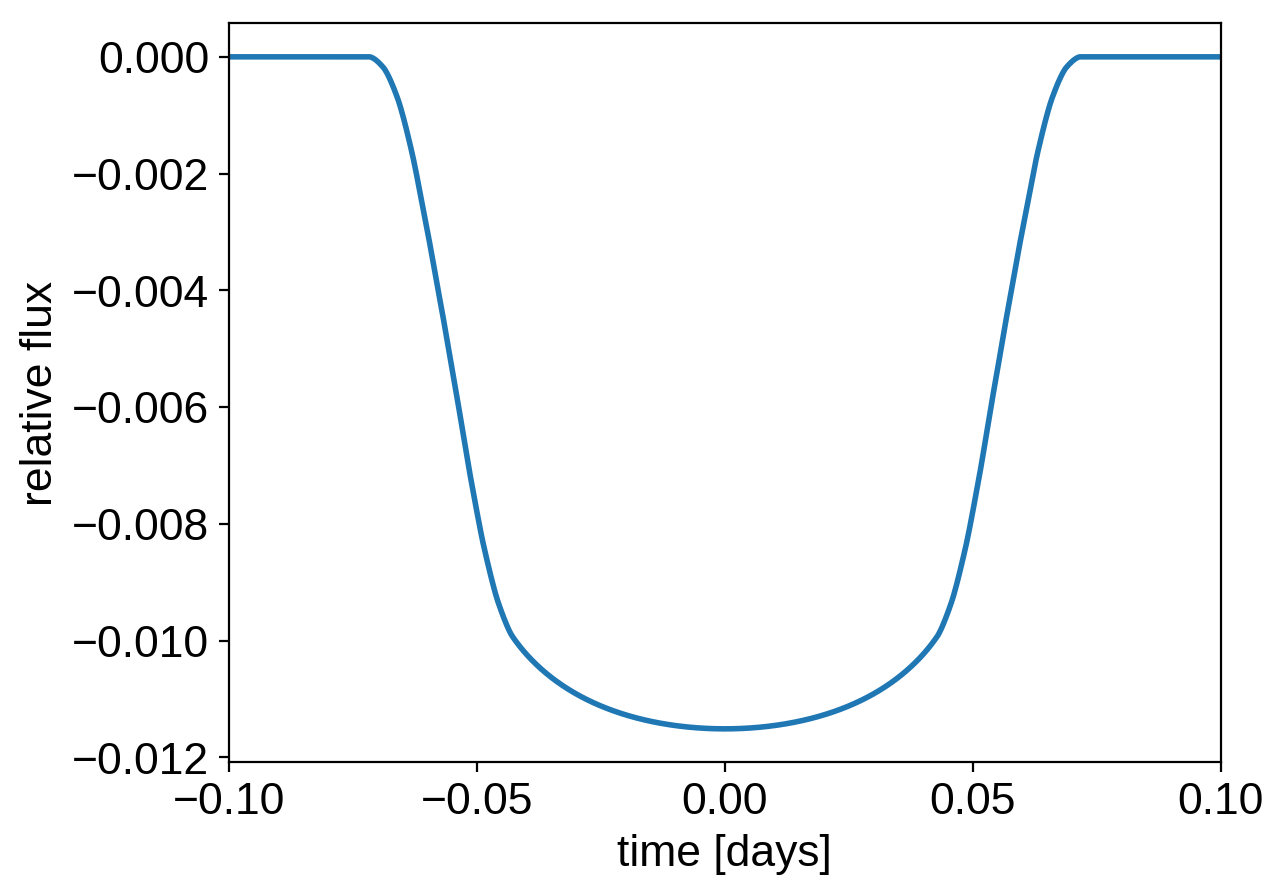

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.LimbDarkLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 24793.972586707856 -> 24799.526978939874


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

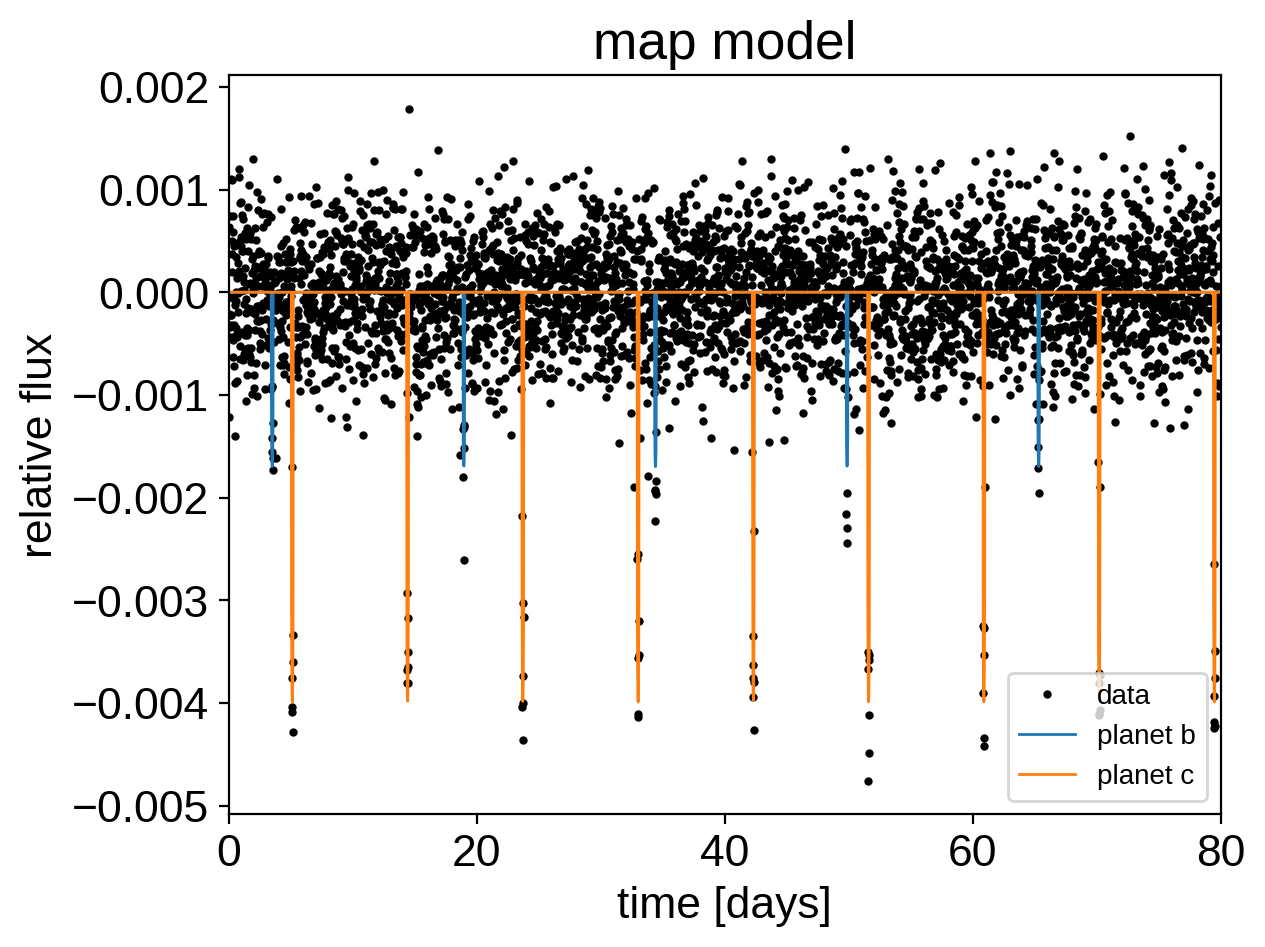

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=3000, draws=3000, start=map_soln, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/24000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/24000 [00:00<02:57, 135.41draws/s]

Sampling 4 chains:   0%|          | 26/24000 [00:00<05:25, 73.70draws/s] 

Sampling 4 chains:   0%|          | 30/24000 [00:00<07:32, 53.00draws/s]

Sampling 4 chains:   0%|          | 34/24000 [00:00<09:00, 44.37draws/s]

Sampling 4 chains:   0%|          | 38/24000 [00:00<10:02, 39.78draws/s]

Sampling 4 chains:   0%|          | 42/24000 [00:00<10:31, 37.93draws/s]

Sampling 4 chains:   0%|          | 46/24000 [00:00<11:03, 36.12draws/s]

Sampling 4 chains:   0%|          | 50/24000 [00:01<11:34, 34.47draws/s]

Sampling 4 chains:   0%|          | 54/24000 [00:01<11:47, 33.83draws/s]

Sampling 4 chains:   0%|          | 59/24000 [00:01<11:12, 35.60draws/s]

Sampling 4 chains:   0%|          | 64/24000 [00:01<10:46, 37.01draws/s]

Sampling 4 chains:   0%|          | 68/24000 [00:01<11:13, 35.55draws/s]

Sampling 4 chains:   0%|          | 72/24000 [00:01<11:32, 34.56draws/s]

Sampling 4 chains:   0%|          | 76/24000 [00:01<11:46, 33.89draws/s]

Sampling 4 chains:   0%|          | 80/24000 [00:01<11:55, 33.45draws/s]

Sampling 4 chains:   0%|          | 84/24000 [00:02<12:00, 33.18draws/s]

Sampling 4 chains:   0%|          | 88/24000 [00:02<12:04, 33.02draws/s]

Sampling 4 chains:   0%|          | 92/24000 [00:02<11:55, 33.39draws/s]

Sampling 4 chains:   0%|          | 96/24000 [00:02<11:57, 33.33draws/s]

Sampling 4 chains:   0%|          | 100/24000 [00:02<12:04, 32.98draws/s]

Sampling 4 chains:   0%|          | 105/24000 [00:02<11:25, 34.84draws/s]

Sampling 4 chains:   0%|          | 109/24000 [00:02<11:42, 34.02draws/s]

Sampling 4 chains:   0%|          | 113/24000 [00:02<11:53, 33.46draws/s]

Sampling 4 chains:   0%|          | 117/24000 [00:03<12:00, 33.17draws/s]

Sampling 4 chains:   1%|          | 121/24000 [00:03<12:03, 33.02draws/s]

Sampling 4 chains:   1%|          | 125/24000 [00:03<12:05, 32.90draws/s]

Sampling 4 chains:   1%|          | 129/24000 [00:03<12:07, 32.80draws/s]

Sampling 4 chains:   1%|          | 133/24000 [00:03<12:08, 32.77draws/s]

Sampling 4 chains:   1%|          | 137/24000 [00:03<12:08, 32.78draws/s]

Sampling 4 chains:   1%|          | 141/24000 [00:03<12:09, 32.73draws/s]

Sampling 4 chains:   1%|          | 145/24000 [00:03<12:09, 32.68draws/s]

Sampling 4 chains:   1%|          | 149/24000 [00:03<12:10, 32.65draws/s]

Sampling 4 chains:   1%|          | 155/24000 [00:04<10:58, 36.22draws/s]

Sampling 4 chains:   1%|          | 159/24000 [00:04<11:20, 35.03draws/s]

Sampling 4 chains:   1%|          | 163/24000 [00:04<11:37, 34.19draws/s]

Sampling 4 chains:   1%|          | 167/24000 [00:04<11:47, 33.71draws/s]

Sampling 4 chains:   1%|          | 171/24000 [00:04<11:54, 33.33draws/s]

Sampling 4 chains:   1%|          | 175/24000 [00:04<12:00, 33.06draws/s]

Sampling 4 chains:   1%|          | 179/24000 [00:04<12:04, 32.88draws/s]

Sampling 4 chains:   1%|          | 183/24000 [00:04<12:06, 32.81draws/s]

Sampling 4 chains:   1%|          | 187/24000 [00:05<12:06, 32.76draws/s]

Sampling 4 chains:   1%|          | 191/24000 [00:05<12:08, 32.69draws/s]

Sampling 4 chains:   1%|          | 195/24000 [00:05<12:10, 32.58draws/s]

Sampling 4 chains:   1%|          | 199/24000 [00:05<12:20, 32.13draws/s]

Sampling 4 chains:   1%|          | 203/24000 [00:05<12:27, 31.84draws/s]

Sampling 4 chains:   1%|          | 207/24000 [00:05<12:31, 31.66draws/s]

Sampling 4 chains:   1%|          | 211/24000 [00:05<12:34, 31.54draws/s]

Sampling 4 chains:   1%|          | 215/24000 [00:05<12:36, 31.44draws/s]

Sampling 4 chains:   1%|          | 219/24000 [00:06<12:45, 31.08draws/s]

Sampling 4 chains:   1%|          | 223/24000 [00:06<12:44, 31.12draws/s]

Sampling 4 chains:   1%|          | 227/24000 [00:06<12:39, 31.32draws/s]

Sampling 4 chains:   1%|          | 231/24000 [00:06<12:32, 31.59draws/s]

Sampling 4 chains:   1%|          | 235/24000 [00:06<12:27, 31.79draws/s]

Sampling 4 chains:   1%|          | 239/24000 [00:06<12:24, 31.92draws/s]

Sampling 4 chains:   1%|          | 244/24000 [00:06<11:46, 33.64draws/s]

Sampling 4 chains:   1%|          | 248/24000 [00:06<11:55, 33.18draws/s]

Sampling 4 chains:   1%|          | 252/24000 [00:07<12:06, 32.69draws/s]

Sampling 4 chains:   1%|          | 256/24000 [00:07<12:09, 32.56draws/s]

Sampling 4 chains:   1%|          | 260/24000 [00:07<12:09, 32.52draws/s]

Sampling 4 chains:   1%|          | 264/24000 [00:07<12:11, 32.45draws/s]

Sampling 4 chains:   1%|          | 268/24000 [00:07<12:15, 32.28draws/s]

Sampling 4 chains:   1%|          | 272/24000 [00:07<12:15, 32.24draws/s]

Sampling 4 chains:   1%|          | 276/24000 [00:07<12:16, 32.22draws/s]

Sampling 4 chains:   1%|          | 281/24000 [00:07<11:31, 34.31draws/s]

Sampling 4 chains:   1%|          | 285/24000 [00:08<11:44, 33.66draws/s]

Sampling 4 chains:   1%|          | 289/24000 [00:08<11:53, 33.23draws/s]

Sampling 4 chains:   1%|          | 293/24000 [00:08<11:59, 32.94draws/s]

Sampling 4 chains:   1%|          | 297/24000 [00:08<12:04, 32.72draws/s]

Sampling 4 chains:   1%|▏         | 301/24000 [00:08<12:07, 32.59draws/s]

Sampling 4 chains:   1%|▏         | 305/24000 [00:08<12:09, 32.50draws/s]

Sampling 4 chains:   1%|▏         | 309/24000 [00:08<12:11, 32.40draws/s]

Sampling 4 chains:   1%|▏         | 313/24000 [00:08<12:12, 32.36draws/s]

Sampling 4 chains:   1%|▏         | 317/24000 [00:09<11:54, 33.14draws/s]

Sampling 4 chains:   1%|▏         | 321/24000 [00:09<12:01, 32.80draws/s]

Sampling 4 chains:   1%|▏         | 325/24000 [00:09<12:07, 32.55draws/s]

Sampling 4 chains:   1%|▏         | 329/24000 [00:09<12:11, 32.37draws/s]

Sampling 4 chains:   1%|▏         | 333/24000 [00:09<12:14, 32.24draws/s]

Sampling 4 chains:   1%|▏         | 337/24000 [00:09<12:16, 32.14draws/s]

Sampling 4 chains:   1%|▏         | 341/24000 [00:09<12:16, 32.12draws/s]

Sampling 4 chains:   1%|▏         | 345/24000 [00:09<12:16, 32.13draws/s]

Sampling 4 chains:   1%|▏         | 349/24000 [00:10<12:18, 32.03draws/s]

Sampling 4 chains:   1%|▏         | 353/24000 [00:10<12:18, 32.04draws/s]

Sampling 4 chains:   1%|▏         | 357/24000 [00:10<12:23, 31.79draws/s]

Sampling 4 chains:   2%|▏         | 361/24000 [00:10<12:25, 31.69draws/s]

Sampling 4 chains:   2%|▏         | 365/24000 [00:10<12:25, 31.71draws/s]

Sampling 4 chains:   2%|▏         | 369/24000 [00:10<12:19, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 373/24000 [00:10<12:14, 32.17draws/s]

Sampling 4 chains:   2%|▏         | 377/24000 [00:10<12:11, 32.28draws/s]

Sampling 4 chains:   2%|▏         | 381/24000 [00:11<12:20, 31.88draws/s]

Sampling 4 chains:   2%|▏         | 385/24000 [00:11<12:18, 31.96draws/s]

Sampling 4 chains:   2%|▏         | 389/24000 [00:11<12:16, 32.06draws/s]

Sampling 4 chains:   2%|▏         | 393/24000 [00:11<12:14, 32.13draws/s]

Sampling 4 chains:   2%|▏         | 397/24000 [00:11<12:14, 32.12draws/s]

Sampling 4 chains:   2%|▏         | 401/24000 [00:11<12:14, 32.12draws/s]

Sampling 4 chains:   2%|▏         | 405/24000 [00:11<11:40, 33.70draws/s]

Sampling 4 chains:   2%|▏         | 409/24000 [00:11<11:48, 33.32draws/s]

Sampling 4 chains:   2%|▏         | 413/24000 [00:12<11:56, 32.93draws/s]

Sampling 4 chains:   2%|▏         | 417/24000 [00:12<12:02, 32.63draws/s]

Sampling 4 chains:   2%|▏         | 421/24000 [00:12<12:06, 32.44draws/s]

Sampling 4 chains:   2%|▏         | 425/24000 [00:12<12:09, 32.31draws/s]

Sampling 4 chains:   2%|▏         | 429/24000 [00:12<12:23, 31.72draws/s]

Sampling 4 chains:   2%|▏         | 433/24000 [00:12<12:22, 31.75draws/s]

Sampling 4 chains:   2%|▏         | 437/24000 [00:12<12:20, 31.80draws/s]

Sampling 4 chains:   2%|▏         | 441/24000 [00:12<12:19, 31.87draws/s]

Sampling 4 chains:   2%|▏         | 445/24000 [00:13<12:17, 31.92draws/s]

Sampling 4 chains:   2%|▏         | 449/24000 [00:13<12:18, 31.91draws/s]

Sampling 4 chains:   2%|▏         | 453/24000 [00:13<12:17, 31.92draws/s]

Sampling 4 chains:   2%|▏         | 457/24000 [00:13<12:18, 31.86draws/s]

Sampling 4 chains:   2%|▏         | 461/24000 [00:13<12:16, 31.94draws/s]

Sampling 4 chains:   2%|▏         | 465/24000 [00:13<12:20, 31.77draws/s]

Sampling 4 chains:   2%|▏         | 469/24000 [00:13<12:18, 31.86draws/s]

Sampling 4 chains:   2%|▏         | 473/24000 [00:13<12:17, 31.89draws/s]

Sampling 4 chains:   2%|▏         | 477/24000 [00:14<12:17, 31.88draws/s]

Sampling 4 chains:   2%|▏         | 481/24000 [00:14<12:17, 31.90draws/s]

Sampling 4 chains:   2%|▏         | 485/24000 [00:14<12:15, 31.98draws/s]

Sampling 4 chains:   2%|▏         | 489/24000 [00:14<12:15, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 493/24000 [00:14<12:15, 31.95draws/s]

Sampling 4 chains:   2%|▏         | 497/24000 [00:14<12:15, 31.95draws/s]

Sampling 4 chains:   2%|▏         | 501/24000 [00:14<12:15, 31.96draws/s]

Sampling 4 chains:   2%|▏         | 505/24000 [00:14<12:14, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 509/24000 [00:15<12:14, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 513/24000 [00:15<12:15, 31.93draws/s]

Sampling 4 chains:   2%|▏         | 517/24000 [00:15<12:15, 31.95draws/s]

Sampling 4 chains:   2%|▏         | 521/24000 [00:15<12:14, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 525/24000 [00:15<12:14, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 529/24000 [00:15<12:16, 31.86draws/s]

Sampling 4 chains:   2%|▏         | 533/24000 [00:15<12:17, 31.83draws/s]

Sampling 4 chains:   2%|▏         | 537/24000 [00:15<12:21, 31.66draws/s]

Sampling 4 chains:   2%|▏         | 541/24000 [00:16<12:19, 31.70draws/s]

Sampling 4 chains:   2%|▏         | 545/24000 [00:16<12:17, 31.80draws/s]

Sampling 4 chains:   2%|▏         | 549/24000 [00:16<12:15, 31.87draws/s]

Sampling 4 chains:   2%|▏         | 553/24000 [00:16<12:15, 31.90draws/s]

Sampling 4 chains:   2%|▏         | 557/24000 [00:16<12:12, 31.99draws/s]

Sampling 4 chains:   2%|▏         | 561/24000 [00:16<12:12, 32.01draws/s]

Sampling 4 chains:   2%|▏         | 565/24000 [00:16<12:11, 32.04draws/s]

Sampling 4 chains:   2%|▏         | 569/24000 [00:16<11:42, 33.34draws/s]

Sampling 4 chains:   2%|▏         | 573/24000 [00:17<11:38, 33.55draws/s]

Sampling 4 chains:   2%|▏         | 577/24000 [00:17<11:45, 33.20draws/s]

Sampling 4 chains:   2%|▏         | 581/24000 [00:17<11:52, 32.88draws/s]

Sampling 4 chains:   2%|▏         | 585/24000 [00:17<11:55, 32.74draws/s]

Sampling 4 chains:   2%|▏         | 589/24000 [00:17<11:58, 32.59draws/s]

Sampling 4 chains:   2%|▏         | 593/24000 [00:17<12:22, 31.52draws/s]

Sampling 4 chains:   2%|▏         | 597/24000 [00:17<12:24, 31.45draws/s]

Sampling 4 chains:   3%|▎         | 602/24000 [00:17<11:40, 33.40draws/s]

Sampling 4 chains:   3%|▎         | 609/24000 [00:18<09:58, 39.06draws/s]

Sampling 4 chains:   3%|▎         | 614/24000 [00:18<09:32, 40.85draws/s]

Sampling 4 chains:   3%|▎         | 621/24000 [00:18<08:25, 46.29draws/s]

Sampling 4 chains:   3%|▎         | 627/24000 [00:18<08:17, 46.99draws/s]

Sampling 4 chains:   3%|▎         | 638/24000 [00:18<06:53, 56.53draws/s]

Sampling 4 chains:   3%|▎         | 649/24000 [00:18<05:54, 65.85draws/s]

Sampling 4 chains:   3%|▎         | 664/24000 [00:18<04:55, 79.00draws/s]

Sampling 4 chains:   3%|▎         | 688/24000 [00:18<03:56, 98.47draws/s]

Sampling 4 chains:   3%|▎         | 721/24000 [00:18<03:07, 123.92draws/s]

Sampling 4 chains:   3%|▎         | 750/24000 [00:19<02:35, 149.17draws/s]

Sampling 4 chains:   3%|▎         | 788/24000 [00:19<02:07, 182.23draws/s]

Sampling 4 chains:   3%|▎         | 823/24000 [00:19<01:48, 212.77draws/s]

Sampling 4 chains:   4%|▎         | 859/24000 [00:19<01:35, 242.49draws/s]

Sampling 4 chains:   4%|▎         | 897/24000 [00:19<01:25, 270.65draws/s]

Sampling 4 chains:   4%|▍         | 930/24000 [00:19<01:20, 285.84draws/s]

Sampling 4 chains:   4%|▍         | 975/24000 [00:19<01:11, 320.11draws/s]

Sampling 4 chains:   4%|▍         | 1026/24000 [00:19<01:03, 359.30draws/s]

Sampling 4 chains:   4%|▍         | 1079/24000 [00:19<00:58, 392.20draws/s]

Sampling 4 chains:   5%|▍         | 1131/24000 [00:19<00:54, 422.73draws/s]

Sampling 4 chains:   5%|▍         | 1184/24000 [00:20<00:50, 447.67draws/s]

Sampling 4 chains:   5%|▌         | 1232/24000 [00:20<00:51, 445.20draws/s]

Sampling 4 chains:   5%|▌         | 1279/24000 [00:20<00:50, 445.92draws/s]

Sampling 4 chains:   6%|▌         | 1331/24000 [00:20<00:48, 464.37draws/s]

Sampling 4 chains:   6%|▌         | 1381/24000 [00:20<00:47, 474.08draws/s]

Sampling 4 chains:   6%|▌         | 1435/24000 [00:20<00:46, 490.14draws/s]

Sampling 4 chains:   6%|▌         | 1494/24000 [00:20<00:43, 516.09draws/s]

Sampling 4 chains:   6%|▋         | 1549/24000 [00:20<00:42, 524.14draws/s]

Sampling 4 chains:   7%|▋         | 1603/24000 [00:20<00:43, 520.49draws/s]

Sampling 4 chains:   7%|▋         | 1656/24000 [00:20<00:44, 504.91draws/s]

Sampling 4 chains:   7%|▋         | 1708/24000 [00:21<00:43, 508.48draws/s]

Sampling 4 chains:   7%|▋         | 1760/24000 [00:21<00:45, 488.26draws/s]

Sampling 4 chains:   8%|▊         | 1810/24000 [00:21<00:45, 487.73draws/s]

Sampling 4 chains:   8%|▊         | 1861/24000 [00:21<00:44, 493.80draws/s]

Sampling 4 chains:   8%|▊         | 1912/24000 [00:21<00:44, 496.38draws/s]

Sampling 4 chains:   8%|▊         | 1963/24000 [00:21<00:44, 500.12draws/s]

Sampling 4 chains:   8%|▊         | 2014/24000 [00:21<00:43, 500.16draws/s]

Sampling 4 chains:   9%|▊         | 2065/24000 [00:21<00:44, 495.12draws/s]

Sampling 4 chains:   9%|▉         | 2116/24000 [00:21<00:43, 499.44draws/s]

Sampling 4 chains:   9%|▉         | 2166/24000 [00:21<00:44, 492.82draws/s]

Sampling 4 chains:   9%|▉         | 2216/24000 [00:22<00:44, 489.19draws/s]

Sampling 4 chains:   9%|▉         | 2272/24000 [00:22<00:43, 502.11draws/s]

Sampling 4 chains:  10%|▉         | 2328/24000 [00:22<00:41, 517.64draws/s]

Sampling 4 chains:  10%|▉         | 2380/24000 [00:22<00:41, 517.13draws/s]

Sampling 4 chains:  10%|█         | 2436/24000 [00:22<00:40, 528.28draws/s]

Sampling 4 chains:  10%|█         | 2489/24000 [00:22<00:40, 528.27draws/s]

Sampling 4 chains:  11%|█         | 2542/24000 [00:22<00:40, 527.51draws/s]

Sampling 4 chains:  11%|█         | 2600/24000 [00:22<00:39, 538.70draws/s]

Sampling 4 chains:  11%|█         | 2654/24000 [00:22<00:40, 532.10draws/s]

Sampling 4 chains:  11%|█▏        | 2708/24000 [00:23<00:40, 527.35draws/s]

Sampling 4 chains:  12%|█▏        | 2761/24000 [00:23<00:40, 523.14draws/s]

Sampling 4 chains:  12%|█▏        | 2815/24000 [00:23<00:40, 526.77draws/s]

Sampling 4 chains:  12%|█▏        | 2868/24000 [00:23<00:41, 513.01draws/s]

Sampling 4 chains:  12%|█▏        | 2926/24000 [00:23<00:39, 530.61draws/s]

Sampling 4 chains:  12%|█▏        | 2982/24000 [00:23<00:39, 534.97draws/s]

Sampling 4 chains:  13%|█▎        | 3036/24000 [00:23<00:39, 535.89draws/s]

Sampling 4 chains:  13%|█▎        | 3090/24000 [00:23<00:40, 520.62draws/s]

Sampling 4 chains:  13%|█▎        | 3143/24000 [00:23<00:40, 514.32draws/s]

Sampling 4 chains:  13%|█▎        | 3195/24000 [00:23<00:41, 503.15draws/s]

Sampling 4 chains:  14%|█▎        | 3246/24000 [00:24<00:42, 488.45draws/s]

Sampling 4 chains:  14%|█▍        | 3302/24000 [00:24<00:40, 506.62draws/s]

Sampling 4 chains:  14%|█▍        | 3353/24000 [00:24<00:40, 507.03draws/s]

Sampling 4 chains:  14%|█▍        | 3411/24000 [00:24<00:39, 521.39draws/s]

Sampling 4 chains:  14%|█▍        | 3464/24000 [00:24<00:39, 516.59draws/s]

Sampling 4 chains:  15%|█▍        | 3519/24000 [00:24<00:38, 525.91draws/s]

Sampling 4 chains:  15%|█▍        | 3577/24000 [00:24<00:37, 539.70draws/s]

Sampling 4 chains:  15%|█▌        | 3632/24000 [00:24<00:38, 534.47draws/s]

Sampling 4 chains:  15%|█▌        | 3686/24000 [00:24<00:39, 520.00draws/s]

Sampling 4 chains:  16%|█▌        | 3739/24000 [00:25<00:38, 521.17draws/s]

Sampling 4 chains:  16%|█▌        | 3793/24000 [00:25<00:38, 525.77draws/s]

Sampling 4 chains:  16%|█▌        | 3852/24000 [00:25<00:37, 543.50draws/s]

Sampling 4 chains:  16%|█▋        | 3907/24000 [00:25<00:38, 528.14draws/s]

Sampling 4 chains:  17%|█▋        | 3962/24000 [00:25<00:37, 532.05draws/s]

Sampling 4 chains:  17%|█▋        | 4016/24000 [00:25<00:37, 529.99draws/s]

Sampling 4 chains:  17%|█▋        | 4071/24000 [00:25<00:37, 532.02draws/s]

Sampling 4 chains:  17%|█▋        | 4125/24000 [00:25<00:37, 530.72draws/s]

Sampling 4 chains:  17%|█▋        | 4179/24000 [00:25<00:37, 523.30draws/s]

Sampling 4 chains:  18%|█▊        | 4232/24000 [00:25<00:38, 513.90draws/s]

Sampling 4 chains:  18%|█▊        | 4284/24000 [00:26<00:38, 512.83draws/s]

Sampling 4 chains:  18%|█▊        | 4336/24000 [00:26<00:38, 510.95draws/s]

Sampling 4 chains:  18%|█▊        | 4392/24000 [00:26<00:37, 523.56draws/s]

Sampling 4 chains:  19%|█▊        | 4445/24000 [00:26<00:37, 519.15draws/s]

Sampling 4 chains:  19%|█▊        | 4497/24000 [00:26<00:37, 515.57draws/s]

Sampling 4 chains:  19%|█▉        | 4549/24000 [00:26<00:38, 509.91draws/s]

Sampling 4 chains:  19%|█▉        | 4608/24000 [00:26<00:36, 529.58draws/s]

Sampling 4 chains:  19%|█▉        | 4662/24000 [00:26<00:36, 527.57draws/s]

Sampling 4 chains:  20%|█▉        | 4715/24000 [00:26<00:37, 520.86draws/s]

Sampling 4 chains:  20%|█▉        | 4768/24000 [00:26<00:37, 517.30draws/s]

Sampling 4 chains:  20%|██        | 4820/24000 [00:27<00:38, 503.30draws/s]

Sampling 4 chains:  20%|██        | 4871/24000 [00:27<00:38, 500.21draws/s]

Sampling 4 chains:  21%|██        | 4922/24000 [00:27<00:38, 500.63draws/s]

Sampling 4 chains:  21%|██        | 4975/24000 [00:27<00:37, 508.44draws/s]

Sampling 4 chains:  21%|██        | 5028/24000 [00:27<00:36, 513.28draws/s]

Sampling 4 chains:  21%|██        | 5080/24000 [00:27<00:36, 514.46draws/s]

Sampling 4 chains:  21%|██▏       | 5132/24000 [00:27<00:36, 513.32draws/s]

Sampling 4 chains:  22%|██▏       | 5187/24000 [00:27<00:35, 523.07draws/s]

Sampling 4 chains:  22%|██▏       | 5245/24000 [00:27<00:34, 538.17draws/s]

Sampling 4 chains:  22%|██▏       | 5299/24000 [00:27<00:35, 521.67draws/s]

Sampling 4 chains:  22%|██▏       | 5352/24000 [00:28<00:36, 517.88draws/s]

Sampling 4 chains:  23%|██▎       | 5411/24000 [00:28<00:34, 535.40draws/s]

Sampling 4 chains:  23%|██▎       | 5465/24000 [00:28<00:34, 536.69draws/s]

Sampling 4 chains:  23%|██▎       | 5520/24000 [00:28<00:34, 538.67draws/s]

Sampling 4 chains:  23%|██▎       | 5574/24000 [00:28<00:34, 532.90draws/s]

Sampling 4 chains:  23%|██▎       | 5628/24000 [00:28<00:35, 524.64draws/s]

Sampling 4 chains:  24%|██▎       | 5681/24000 [00:28<00:35, 522.65draws/s]

Sampling 4 chains:  24%|██▍       | 5734/24000 [00:28<00:35, 517.03draws/s]

Sampling 4 chains:  24%|██▍       | 5788/24000 [00:28<00:34, 520.90draws/s]

Sampling 4 chains:  24%|██▍       | 5841/24000 [00:29<00:34, 521.95draws/s]

Sampling 4 chains:  25%|██▍       | 5894/24000 [00:29<00:34, 521.42draws/s]

Sampling 4 chains:  25%|██▍       | 5947/24000 [00:29<00:34, 523.25draws/s]

Sampling 4 chains:  25%|██▌       | 6000/24000 [00:29<00:34, 516.88draws/s]

Sampling 4 chains:  25%|██▌       | 6052/24000 [00:29<00:34, 514.29draws/s]

Sampling 4 chains:  25%|██▌       | 6104/24000 [00:29<00:35, 508.97draws/s]

Sampling 4 chains:  26%|██▌       | 6156/24000 [00:29<00:35, 509.69draws/s]

Sampling 4 chains:  26%|██▌       | 6207/24000 [00:29<00:35, 506.63draws/s]

Sampling 4 chains:  26%|██▌       | 6259/24000 [00:29<00:34, 510.04draws/s]

Sampling 4 chains:  26%|██▋       | 6312/24000 [00:29<00:34, 515.10draws/s]

Sampling 4 chains:  27%|██▋       | 6365/24000 [00:30<00:34, 518.46draws/s]

Sampling 4 chains:  27%|██▋       | 6417/24000 [00:30<00:34, 517.04draws/s]

Sampling 4 chains:  27%|██▋       | 6469/24000 [00:30<00:34, 515.17draws/s]

Sampling 4 chains:  27%|██▋       | 6523/24000 [00:30<00:33, 522.03draws/s]

Sampling 4 chains:  27%|██▋       | 6576/24000 [00:30<00:33, 518.92draws/s]

Sampling 4 chains:  28%|██▊       | 6634/24000 [00:30<00:32, 533.88draws/s]

Sampling 4 chains:  28%|██▊       | 6688/24000 [00:30<00:32, 531.19draws/s]

Sampling 4 chains:  28%|██▊       | 6742/24000 [00:30<00:33, 517.64draws/s]

Sampling 4 chains:  28%|██▊       | 6797/24000 [00:30<00:32, 525.28draws/s]

Sampling 4 chains:  29%|██▊       | 6851/24000 [00:30<00:32, 526.74draws/s]

Sampling 4 chains:  29%|██▉       | 6905/24000 [00:31<00:32, 529.40draws/s]

Sampling 4 chains:  29%|██▉       | 6959/24000 [00:31<00:32, 531.13draws/s]

Sampling 4 chains:  29%|██▉       | 7013/24000 [00:31<00:32, 530.73draws/s]

Sampling 4 chains:  29%|██▉       | 7067/24000 [00:31<00:32, 522.13draws/s]

Sampling 4 chains:  30%|██▉       | 7121/24000 [00:31<00:32, 526.51draws/s]

Sampling 4 chains:  30%|██▉       | 7174/24000 [00:31<00:33, 509.18draws/s]

Sampling 4 chains:  30%|███       | 7226/24000 [00:31<00:33, 501.33draws/s]

Sampling 4 chains:  30%|███       | 7277/24000 [00:31<00:33, 499.59draws/s]

Sampling 4 chains:  31%|███       | 7329/24000 [00:31<00:33, 504.06draws/s]

Sampling 4 chains:  31%|███       | 7383/24000 [00:32<00:32, 513.69draws/s]

Sampling 4 chains:  31%|███       | 7436/24000 [00:32<00:31, 517.69draws/s]

Sampling 4 chains:  31%|███       | 7488/24000 [00:32<00:32, 505.92draws/s]

Sampling 4 chains:  31%|███▏      | 7541/24000 [00:32<00:32, 507.81draws/s]

Sampling 4 chains:  32%|███▏      | 7593/24000 [00:32<00:32, 511.30draws/s]

Sampling 4 chains:  32%|███▏      | 7645/24000 [00:32<00:32, 506.06draws/s]

Sampling 4 chains:  32%|███▏      | 7702/24000 [00:32<00:31, 520.27draws/s]

Sampling 4 chains:  32%|███▏      | 7756/24000 [00:32<00:31, 523.26draws/s]

Sampling 4 chains:  33%|███▎      | 7809/24000 [00:32<00:30, 522.86draws/s]

Sampling 4 chains:  33%|███▎      | 7862/24000 [00:32<00:31, 519.37draws/s]

Sampling 4 chains:  33%|███▎      | 7914/24000 [00:33<00:31, 517.33draws/s]

Sampling 4 chains:  33%|███▎      | 7971/24000 [00:33<00:30, 530.66draws/s]

Sampling 4 chains:  33%|███▎      | 8025/24000 [00:33<00:30, 531.27draws/s]

Sampling 4 chains:  34%|███▎      | 8079/24000 [00:33<00:30, 523.17draws/s]

Sampling 4 chains:  34%|███▍      | 8133/24000 [00:33<00:30, 527.01draws/s]

Sampling 4 chains:  34%|███▍      | 8186/24000 [00:33<00:30, 526.46draws/s]

Sampling 4 chains:  34%|███▍      | 8239/24000 [00:33<00:29, 526.34draws/s]

Sampling 4 chains:  35%|███▍      | 8292/24000 [00:33<00:29, 524.48draws/s]

Sampling 4 chains:  35%|███▍      | 8346/24000 [00:33<00:29, 528.00draws/s]

Sampling 4 chains:  35%|███▌      | 8400/24000 [00:33<00:29, 529.69draws/s]

Sampling 4 chains:  35%|███▌      | 8455/24000 [00:34<00:29, 535.07draws/s]

Sampling 4 chains:  35%|███▌      | 8509/24000 [00:34<00:29, 519.18draws/s]

Sampling 4 chains:  36%|███▌      | 8562/24000 [00:34<00:29, 518.52draws/s]

Sampling 4 chains:  36%|███▌      | 8617/24000 [00:34<00:29, 523.95draws/s]

Sampling 4 chains:  36%|███▌      | 8670/24000 [00:34<00:29, 522.52draws/s]

Sampling 4 chains:  36%|███▋      | 8723/24000 [00:34<00:29, 519.41draws/s]

Sampling 4 chains:  37%|███▋      | 8778/24000 [00:34<00:28, 528.08draws/s]

Sampling 4 chains:  37%|███▋      | 8833/24000 [00:34<00:28, 533.40draws/s]

Sampling 4 chains:  37%|███▋      | 8887/24000 [00:34<00:28, 527.76draws/s]

Sampling 4 chains:  37%|███▋      | 8940/24000 [00:34<00:28, 520.26draws/s]

Sampling 4 chains:  37%|███▋      | 8993/24000 [00:35<00:28, 520.49draws/s]

Sampling 4 chains:  38%|███▊      | 9048/24000 [00:35<00:28, 528.54draws/s]

Sampling 4 chains:  38%|███▊      | 9105/24000 [00:35<00:27, 539.81draws/s]

Sampling 4 chains:  38%|███▊      | 9160/24000 [00:35<00:27, 536.23draws/s]

Sampling 4 chains:  38%|███▊      | 9214/24000 [00:35<00:27, 533.36draws/s]

Sampling 4 chains:  39%|███▊      | 9273/24000 [00:35<00:26, 546.94draws/s]

Sampling 4 chains:  39%|███▉      | 9329/24000 [00:35<00:26, 549.53draws/s]

Sampling 4 chains:  39%|███▉      | 9386/24000 [00:35<00:26, 555.46draws/s]

Sampling 4 chains:  39%|███▉      | 9442/24000 [00:35<00:26, 551.90draws/s]

Sampling 4 chains:  40%|███▉      | 9498/24000 [00:35<00:26, 552.14draws/s]

Sampling 4 chains:  40%|███▉      | 9554/24000 [00:36<00:26, 546.47draws/s]

Sampling 4 chains:  40%|████      | 9609/24000 [00:36<00:27, 528.56draws/s]

Sampling 4 chains:  40%|████      | 9663/24000 [00:36<00:27, 525.01draws/s]

Sampling 4 chains:  40%|████      | 9716/24000 [00:36<00:28, 506.81draws/s]

Sampling 4 chains:  41%|████      | 9771/24000 [00:36<00:27, 519.04draws/s]

Sampling 4 chains:  41%|████      | 9824/24000 [00:36<00:27, 513.03draws/s]

Sampling 4 chains:  41%|████      | 9876/24000 [00:36<00:27, 510.15draws/s]

Sampling 4 chains:  41%|████▏     | 9930/24000 [00:36<00:27, 518.27draws/s]

Sampling 4 chains:  42%|████▏     | 9982/24000 [00:36<00:27, 508.00draws/s]

Sampling 4 chains:  42%|████▏     | 10033/24000 [00:37<00:27, 507.92draws/s]

Sampling 4 chains:  42%|████▏     | 10087/24000 [00:37<00:26, 516.14draws/s]

Sampling 4 chains:  42%|████▏     | 10141/24000 [00:37<00:26, 520.87draws/s]

Sampling 4 chains:  42%|████▏     | 10196/24000 [00:37<00:26, 528.85draws/s]

Sampling 4 chains:  43%|████▎     | 10251/24000 [00:37<00:25, 534.23draws/s]

Sampling 4 chains:  43%|████▎     | 10305/24000 [00:37<00:25, 528.30draws/s]

Sampling 4 chains:  43%|████▎     | 10362/24000 [00:37<00:25, 537.20draws/s]

Sampling 4 chains:  43%|████▎     | 10416/24000 [00:37<00:25, 527.33draws/s]

Sampling 4 chains:  44%|████▎     | 10469/24000 [00:37<00:25, 521.62draws/s]

Sampling 4 chains:  44%|████▍     | 10522/24000 [00:37<00:25, 520.91draws/s]

Sampling 4 chains:  44%|████▍     | 10575/24000 [00:38<00:25, 518.44draws/s]

Sampling 4 chains:  44%|████▍     | 10631/24000 [00:38<00:25, 526.79draws/s]

Sampling 4 chains:  45%|████▍     | 10687/24000 [00:38<00:25, 532.19draws/s]

Sampling 4 chains:  45%|████▍     | 10743/24000 [00:38<00:24, 538.50draws/s]

Sampling 4 chains:  45%|████▌     | 10801/24000 [00:38<00:24, 548.44draws/s]

Sampling 4 chains:  45%|████▌     | 10856/24000 [00:38<00:24, 544.07draws/s]

Sampling 4 chains:  45%|████▌     | 10911/24000 [00:38<00:24, 541.36draws/s]

Sampling 4 chains:  46%|████▌     | 10969/24000 [00:38<00:23, 549.46draws/s]

Sampling 4 chains:  46%|████▌     | 11026/24000 [00:38<00:23, 553.84draws/s]

Sampling 4 chains:  46%|████▌     | 11082/24000 [00:38<00:23, 549.91draws/s]

Sampling 4 chains:  46%|████▋     | 11138/24000 [00:39<00:23, 549.68draws/s]

Sampling 4 chains:  47%|████▋     | 11193/24000 [00:39<00:23, 539.63draws/s]

Sampling 4 chains:  47%|████▋     | 11248/24000 [00:39<00:23, 539.77draws/s]

Sampling 4 chains:  47%|████▋     | 11303/24000 [00:39<00:23, 539.83draws/s]

Sampling 4 chains:  47%|████▋     | 11358/24000 [00:39<00:23, 539.16draws/s]

Sampling 4 chains:  48%|████▊     | 11412/24000 [00:39<00:23, 536.09draws/s]

Sampling 4 chains:  48%|████▊     | 11466/24000 [00:39<00:23, 529.05draws/s]

Sampling 4 chains:  48%|████▊     | 11521/24000 [00:39<00:23, 535.12draws/s]

Sampling 4 chains:  48%|████▊     | 11575/24000 [00:39<00:23, 536.33draws/s]

Sampling 4 chains:  48%|████▊     | 11630/24000 [00:40<00:22, 538.51draws/s]

Sampling 4 chains:  49%|████▊     | 11684/24000 [00:40<00:23, 532.94draws/s]

Sampling 4 chains:  49%|████▉     | 11738/24000 [00:40<00:23, 532.64draws/s]

Sampling 4 chains:  49%|████▉     | 11796/24000 [00:40<00:22, 543.88draws/s]

Sampling 4 chains:  49%|████▉     | 11851/24000 [00:40<00:22, 539.51draws/s]

Sampling 4 chains:  50%|████▉     | 11909/24000 [00:40<00:22, 548.93draws/s]

Sampling 4 chains:  50%|████▉     | 11968/24000 [00:40<00:21, 558.58draws/s]

Sampling 4 chains:  50%|█████     | 12025/24000 [00:40<00:21, 559.20draws/s]

Sampling 4 chains:  50%|█████     | 12081/24000 [00:40<00:21, 554.61draws/s]

Sampling 4 chains:  51%|█████     | 12137/24000 [00:40<00:21, 550.04draws/s]

Sampling 4 chains:  51%|█████     | 12193/24000 [00:41<00:21, 540.55draws/s]

Sampling 4 chains:  51%|█████     | 12248/24000 [00:41<00:22, 530.39draws/s]

Sampling 4 chains:  51%|█████▏    | 12303/24000 [00:41<00:21, 534.20draws/s]

Sampling 4 chains:  51%|█████▏    | 12357/24000 [00:41<00:22, 527.91draws/s]

Sampling 4 chains:  52%|█████▏    | 12411/24000 [00:41<00:21, 529.92draws/s]

Sampling 4 chains:  52%|█████▏    | 12467/24000 [00:41<00:21, 535.68draws/s]

Sampling 4 chains:  52%|█████▏    | 12524/24000 [00:41<00:21, 544.51draws/s]

Sampling 4 chains:  52%|█████▏    | 12581/24000 [00:41<00:20, 550.40draws/s]

Sampling 4 chains:  53%|█████▎    | 12637/24000 [00:41<00:20, 547.03draws/s]

Sampling 4 chains:  53%|█████▎    | 12697/24000 [00:41<00:20, 558.48draws/s]

Sampling 4 chains:  53%|█████▎    | 12753/24000 [00:42<00:20, 558.14draws/s]

Sampling 4 chains:  53%|█████▎    | 12809/24000 [00:42<00:20, 551.77draws/s]

Sampling 4 chains:  54%|█████▎    | 12865/24000 [00:42<00:20, 540.88draws/s]

Sampling 4 chains:  54%|█████▍    | 12920/24000 [00:42<00:20, 539.42draws/s]

Sampling 4 chains:  54%|█████▍    | 12975/24000 [00:42<00:20, 540.51draws/s]

Sampling 4 chains:  54%|█████▍    | 13030/24000 [00:42<00:20, 540.93draws/s]

Sampling 4 chains:  55%|█████▍    | 13085/24000 [00:42<00:20, 538.28draws/s]

Sampling 4 chains:  55%|█████▍    | 13139/24000 [00:42<00:20, 534.51draws/s]

Sampling 4 chains:  55%|█████▍    | 13197/24000 [00:42<00:19, 544.76draws/s]

Sampling 4 chains:  55%|█████▌    | 13252/24000 [00:43<00:19, 540.94draws/s]

Sampling 4 chains:  55%|█████▌    | 13308/24000 [00:43<00:19, 538.74draws/s]

Sampling 4 chains:  56%|█████▌    | 13362/24000 [00:43<00:19, 538.43draws/s]

Sampling 4 chains:  56%|█████▌    | 13419/24000 [00:43<00:19, 546.41draws/s]

Sampling 4 chains:  56%|█████▌    | 13474/24000 [00:43<00:19, 542.96draws/s]

Sampling 4 chains:  56%|█████▋    | 13529/24000 [00:43<00:19, 535.60draws/s]

Sampling 4 chains:  57%|█████▋    | 13586/24000 [00:43<00:19, 544.65draws/s]

Sampling 4 chains:  57%|█████▋    | 13641/24000 [00:43<00:19, 539.72draws/s]

Sampling 4 chains:  57%|█████▋    | 13696/24000 [00:43<00:19, 527.04draws/s]

Sampling 4 chains:  57%|█████▋    | 13751/24000 [00:43<00:19, 532.47draws/s]

Sampling 4 chains:  58%|█████▊    | 13809/24000 [00:44<00:18, 543.99draws/s]

Sampling 4 chains:  58%|█████▊    | 13864/24000 [00:44<00:18, 542.99draws/s]

Sampling 4 chains:  58%|█████▊    | 13919/24000 [00:44<00:18, 544.55draws/s]

Sampling 4 chains:  58%|█████▊    | 13974/24000 [00:44<00:18, 540.34draws/s]

Sampling 4 chains:  58%|█████▊    | 14029/24000 [00:44<00:18, 531.81draws/s]

Sampling 4 chains:  59%|█████▊    | 14084/24000 [00:44<00:18, 536.94draws/s]

Sampling 4 chains:  59%|█████▉    | 14138/24000 [00:44<00:18, 533.59draws/s]

Sampling 4 chains:  59%|█████▉    | 14192/24000 [00:44<00:18, 531.79draws/s]

Sampling 4 chains:  59%|█████▉    | 14247/24000 [00:44<00:18, 529.96draws/s]

Sampling 4 chains:  60%|█████▉    | 14302/24000 [00:44<00:18, 535.40draws/s]

Sampling 4 chains:  60%|█████▉    | 14356/24000 [00:45<00:18, 533.34draws/s]

Sampling 4 chains:  60%|██████    | 14410/24000 [00:45<00:18, 531.47draws/s]

Sampling 4 chains:  60%|██████    | 14464/24000 [00:45<00:17, 533.16draws/s]

Sampling 4 chains:  60%|██████    | 14518/24000 [00:45<00:18, 525.82draws/s]

Sampling 4 chains:  61%|██████    | 14571/24000 [00:45<00:17, 526.19draws/s]

Sampling 4 chains:  61%|██████    | 14625/24000 [00:45<00:17, 528.43draws/s]

Sampling 4 chains:  61%|██████    | 14679/24000 [00:45<00:17, 530.51draws/s]

Sampling 4 chains:  61%|██████▏   | 14733/24000 [00:45<00:17, 528.37draws/s]

Sampling 4 chains:  62%|██████▏   | 14787/24000 [00:45<00:17, 530.76draws/s]

Sampling 4 chains:  62%|██████▏   | 14841/24000 [00:45<00:17, 527.43draws/s]

Sampling 4 chains:  62%|██████▏   | 14894/24000 [00:46<00:17, 523.36draws/s]

Sampling 4 chains:  62%|██████▏   | 14947/24000 [00:46<00:17, 524.86draws/s]

Sampling 4 chains:  62%|██████▎   | 15000/24000 [00:46<00:17, 518.90draws/s]

Sampling 4 chains:  63%|██████▎   | 15054/24000 [00:46<00:17, 524.60draws/s]

Sampling 4 chains:  63%|██████▎   | 15110/24000 [00:46<00:16, 532.97draws/s]

Sampling 4 chains:  63%|██████▎   | 15164/24000 [00:46<00:16, 534.11draws/s]

Sampling 4 chains:  63%|██████▎   | 15218/24000 [00:46<00:16, 531.92draws/s]

Sampling 4 chains:  64%|██████▎   | 15272/24000 [00:46<00:16, 527.56draws/s]

Sampling 4 chains:  64%|██████▍   | 15329/24000 [00:46<00:16, 538.75draws/s]

Sampling 4 chains:  64%|██████▍   | 15384/24000 [00:46<00:15, 541.63draws/s]

Sampling 4 chains:  64%|██████▍   | 15439/24000 [00:47<00:15, 535.27draws/s]

Sampling 4 chains:  65%|██████▍   | 15495/24000 [00:47<00:15, 540.93draws/s]

Sampling 4 chains:  65%|██████▍   | 15550/24000 [00:47<00:15, 532.04draws/s]

Sampling 4 chains:  65%|██████▌   | 15606/24000 [00:47<00:15, 540.03draws/s]

Sampling 4 chains:  65%|██████▌   | 15661/24000 [00:47<00:15, 535.95draws/s]

Sampling 4 chains:  65%|██████▌   | 15715/24000 [00:47<00:15, 536.52draws/s]

Sampling 4 chains:  66%|██████▌   | 15773/24000 [00:47<00:15, 547.93draws/s]

Sampling 4 chains:  66%|██████▌   | 15828/24000 [00:47<00:14, 545.86draws/s]

Sampling 4 chains:  66%|██████▌   | 15884/24000 [00:47<00:14, 544.52draws/s]

Sampling 4 chains:  66%|██████▋   | 15942/24000 [00:48<00:14, 553.00draws/s]

Sampling 4 chains:  67%|██████▋   | 15998/24000 [00:48<00:14, 548.07draws/s]

Sampling 4 chains:  67%|██████▋   | 16053/24000 [00:48<00:14, 547.02draws/s]

Sampling 4 chains:  67%|██████▋   | 16112/24000 [00:48<00:14, 557.71draws/s]

Sampling 4 chains:  67%|██████▋   | 16168/24000 [00:48<00:14, 552.09draws/s]

Sampling 4 chains:  68%|██████▊   | 16224/24000 [00:48<00:14, 543.99draws/s]

Sampling 4 chains:  68%|██████▊   | 16279/24000 [00:48<00:14, 545.66draws/s]

Sampling 4 chains:  68%|██████▊   | 16335/24000 [00:48<00:13, 549.19draws/s]

Sampling 4 chains:  68%|██████▊   | 16390/24000 [00:48<00:14, 542.56draws/s]

Sampling 4 chains:  69%|██████▊   | 16445/24000 [00:48<00:13, 541.39draws/s]

Sampling 4 chains:  69%|██████▉   | 16500/24000 [00:49<00:13, 541.08draws/s]

Sampling 4 chains:  69%|██████▉   | 16555/24000 [00:49<00:13, 535.81draws/s]

Sampling 4 chains:  69%|██████▉   | 16612/24000 [00:49<00:13, 544.96draws/s]

Sampling 4 chains:  69%|██████▉   | 16668/24000 [00:49<00:13, 549.09draws/s]

Sampling 4 chains:  70%|██████▉   | 16723/24000 [00:49<00:13, 546.86draws/s]

Sampling 4 chains:  70%|██████▉   | 16778/24000 [00:49<00:13, 544.27draws/s]

Sampling 4 chains:  70%|███████   | 16833/24000 [00:49<00:13, 544.71draws/s]

Sampling 4 chains:  70%|███████   | 16888/24000 [00:49<00:13, 543.87draws/s]

Sampling 4 chains:  71%|███████   | 16943/24000 [00:49<00:13, 539.11draws/s]

Sampling 4 chains:  71%|███████   | 16998/24000 [00:49<00:12, 539.20draws/s]

Sampling 4 chains:  71%|███████   | 17054/24000 [00:50<00:12, 544.55draws/s]

Sampling 4 chains:  71%|███████▏  | 17109/24000 [00:50<00:13, 529.31draws/s]

Sampling 4 chains:  72%|███████▏  | 17163/24000 [00:50<00:12, 526.95draws/s]

Sampling 4 chains:  72%|███████▏  | 17216/24000 [00:50<00:12, 524.58draws/s]

Sampling 4 chains:  72%|███████▏  | 17277/24000 [00:50<00:12, 547.46draws/s]

Sampling 4 chains:  72%|███████▏  | 17333/24000 [00:50<00:12, 544.03draws/s]

Sampling 4 chains:  72%|███████▏  | 17390/24000 [00:50<00:12, 547.35draws/s]

Sampling 4 chains:  73%|███████▎  | 17445/24000 [00:50<00:11, 547.87draws/s]

Sampling 4 chains:  73%|███████▎  | 17500/24000 [00:50<00:11, 544.43draws/s]

Sampling 4 chains:  73%|███████▎  | 17555/24000 [00:51<00:12, 531.81draws/s]

Sampling 4 chains:  73%|███████▎  | 17609/24000 [00:51<00:11, 533.32draws/s]

Sampling 4 chains:  74%|███████▎  | 17663/24000 [00:51<00:11, 530.05draws/s]

Sampling 4 chains:  74%|███████▍  | 17717/24000 [00:51<00:11, 531.76draws/s]

Sampling 4 chains:  74%|███████▍  | 17771/24000 [00:51<00:11, 530.90draws/s]

Sampling 4 chains:  74%|███████▍  | 17829/24000 [00:51<00:11, 541.07draws/s]

Sampling 4 chains:  75%|███████▍  | 17885/24000 [00:51<00:11, 546.08draws/s]

Sampling 4 chains:  75%|███████▍  | 17940/24000 [00:51<00:11, 543.61draws/s]

Sampling 4 chains:  75%|███████▍  | 17996/24000 [00:51<00:10, 547.64draws/s]

Sampling 4 chains:  75%|███████▌  | 18053/24000 [00:51<00:10, 552.16draws/s]

Sampling 4 chains:  75%|███████▌  | 18109/24000 [00:52<00:10, 550.01draws/s]

Sampling 4 chains:  76%|███████▌  | 18165/24000 [00:52<00:10, 547.15draws/s]

Sampling 4 chains:  76%|███████▌  | 18221/24000 [00:52<00:10, 545.56draws/s]

Sampling 4 chains:  76%|███████▌  | 18279/24000 [00:52<00:10, 554.48draws/s]

Sampling 4 chains:  76%|███████▋  | 18335/24000 [00:52<00:10, 554.18draws/s]

Sampling 4 chains:  77%|███████▋  | 18391/24000 [00:52<00:10, 543.21draws/s]

Sampling 4 chains:  77%|███████▋  | 18446/24000 [00:52<00:10, 544.01draws/s]

Sampling 4 chains:  77%|███████▋  | 18501/24000 [00:52<00:10, 538.69draws/s]

Sampling 4 chains:  77%|███████▋  | 18558/24000 [00:52<00:10, 541.54draws/s]

Sampling 4 chains:  78%|███████▊  | 18613/24000 [00:52<00:09, 542.40draws/s]

Sampling 4 chains:  78%|███████▊  | 18671/24000 [00:53<00:09, 551.22draws/s]

Sampling 4 chains:  78%|███████▊  | 18729/24000 [00:53<00:09, 557.42draws/s]

Sampling 4 chains:  78%|███████▊  | 18785/24000 [00:53<00:09, 550.17draws/s]

Sampling 4 chains:  79%|███████▊  | 18841/24000 [00:53<00:09, 547.17draws/s]

Sampling 4 chains:  79%|███████▊  | 18896/24000 [00:53<00:09, 536.28draws/s]

Sampling 4 chains:  79%|███████▉  | 18950/24000 [00:53<00:09, 535.93draws/s]

Sampling 4 chains:  79%|███████▉  | 19006/24000 [00:53<00:09, 537.77draws/s]

Sampling 4 chains:  79%|███████▉  | 19060/24000 [00:53<00:09, 531.99draws/s]

Sampling 4 chains:  80%|███████▉  | 19114/24000 [00:53<00:09, 523.62draws/s]

Sampling 4 chains:  80%|███████▉  | 19168/24000 [00:53<00:09, 525.40draws/s]

Sampling 4 chains:  80%|████████  | 19221/24000 [00:54<00:09, 520.72draws/s]

Sampling 4 chains:  80%|████████  | 19276/24000 [00:54<00:08, 528.33draws/s]

Sampling 4 chains:  81%|████████  | 19329/24000 [00:54<00:08, 527.39draws/s]

Sampling 4 chains:  81%|████████  | 19385/24000 [00:54<00:08, 529.95draws/s]

Sampling 4 chains:  81%|████████  | 19439/24000 [00:54<00:08, 532.19draws/s]

Sampling 4 chains:  81%|████████  | 19493/24000 [00:54<00:08, 525.35draws/s]

Sampling 4 chains:  81%|████████▏ | 19549/24000 [00:54<00:08, 531.00draws/s]

Sampling 4 chains:  82%|████████▏ | 19605/24000 [00:54<00:08, 534.57draws/s]

Sampling 4 chains:  82%|████████▏ | 19659/24000 [00:54<00:08, 527.25draws/s]

Sampling 4 chains:  82%|████████▏ | 19719/24000 [00:55<00:07, 545.23draws/s]

Sampling 4 chains:  82%|████████▏ | 19774/24000 [00:55<00:07, 546.20draws/s]

Sampling 4 chains:  83%|████████▎ | 19829/24000 [00:55<00:07, 538.47draws/s]

Sampling 4 chains:  83%|████████▎ | 19883/24000 [00:55<00:07, 535.07draws/s]

Sampling 4 chains:  83%|████████▎ | 19938/24000 [00:55<00:07, 538.68draws/s]

Sampling 4 chains:  83%|████████▎ | 19992/24000 [00:55<00:07, 535.47draws/s]

Sampling 4 chains:  84%|████████▎ | 20046/24000 [00:55<00:07, 527.78draws/s]

Sampling 4 chains:  84%|████████▎ | 20099/24000 [00:55<00:07, 527.94draws/s]

Sampling 4 chains:  84%|████████▍ | 20155/24000 [00:55<00:07, 536.76draws/s]

Sampling 4 chains:  84%|████████▍ | 20211/24000 [00:55<00:06, 543.31draws/s]

Sampling 4 chains:  84%|████████▍ | 20269/24000 [00:56<00:06, 550.40draws/s]

Sampling 4 chains:  85%|████████▍ | 20325/24000 [00:56<00:06, 551.71draws/s]

Sampling 4 chains:  85%|████████▍ | 20381/24000 [00:56<00:06, 550.16draws/s]

Sampling 4 chains:  85%|████████▌ | 20437/24000 [00:56<00:06, 545.85draws/s]

Sampling 4 chains:  85%|████████▌ | 20492/24000 [00:56<00:06, 543.93draws/s]

Sampling 4 chains:  86%|████████▌ | 20547/24000 [00:56<00:06, 543.30draws/s]

Sampling 4 chains:  86%|████████▌ | 20603/24000 [00:56<00:06, 547.60draws/s]

Sampling 4 chains:  86%|████████▌ | 20658/24000 [00:56<00:06, 540.55draws/s]

Sampling 4 chains:  86%|████████▋ | 20713/24000 [00:56<00:06, 536.46draws/s]

Sampling 4 chains:  87%|████████▋ | 20770/24000 [00:56<00:05, 544.29draws/s]

Sampling 4 chains:  87%|████████▋ | 20825/24000 [00:57<00:05, 535.40draws/s]

Sampling 4 chains:  87%|████████▋ | 20882/24000 [00:57<00:05, 543.53draws/s]

Sampling 4 chains:  87%|████████▋ | 20937/24000 [00:57<00:05, 540.35draws/s]

Sampling 4 chains:  87%|████████▋ | 20992/24000 [00:57<00:05, 540.63draws/s]

Sampling 4 chains:  88%|████████▊ | 21050/24000 [00:57<00:05, 551.28draws/s]

Sampling 4 chains:  88%|████████▊ | 21106/24000 [00:57<00:05, 546.91draws/s]

Sampling 4 chains:  88%|████████▊ | 21161/24000 [00:57<00:05, 545.02draws/s]

Sampling 4 chains:  88%|████████▊ | 21216/24000 [00:57<00:05, 542.91draws/s]

Sampling 4 chains:  89%|████████▊ | 21271/24000 [00:57<00:05, 541.31draws/s]

Sampling 4 chains:  89%|████████▉ | 21326/24000 [00:57<00:04, 541.05draws/s]

Sampling 4 chains:  89%|████████▉ | 21381/24000 [00:58<00:04, 534.46draws/s]

Sampling 4 chains:  89%|████████▉ | 21436/24000 [00:58<00:04, 538.73draws/s]

Sampling 4 chains:  90%|████████▉ | 21492/24000 [00:58<00:04, 544.61draws/s]

Sampling 4 chains:  90%|████████▉ | 21547/24000 [00:58<00:04, 538.32draws/s]

Sampling 4 chains:  90%|█████████ | 21604/24000 [00:58<00:04, 543.01draws/s]

Sampling 4 chains:  90%|█████████ | 21659/24000 [00:58<00:04, 539.05draws/s]

Sampling 4 chains:  90%|█████████ | 21713/24000 [00:58<00:04, 536.06draws/s]

Sampling 4 chains:  91%|█████████ | 21767/24000 [00:58<00:04, 535.26draws/s]

Sampling 4 chains:  91%|█████████ | 21821/24000 [00:58<00:04, 529.24draws/s]

Sampling 4 chains:  91%|█████████ | 21876/24000 [00:59<00:03, 535.01draws/s]

Sampling 4 chains:  91%|█████████▏| 21930/24000 [00:59<00:03, 534.79draws/s]

Sampling 4 chains:  92%|█████████▏| 21984/24000 [00:59<00:03, 535.47draws/s]

Sampling 4 chains:  92%|█████████▏| 22038/24000 [00:59<00:03, 532.73draws/s]

Sampling 4 chains:  92%|█████████▏| 22092/24000 [00:59<00:03, 527.25draws/s]

Sampling 4 chains:  92%|█████████▏| 22148/24000 [00:59<00:03, 536.54draws/s]

Sampling 4 chains:  93%|█████████▎| 22203/24000 [00:59<00:03, 540.17draws/s]

Sampling 4 chains:  93%|█████████▎| 22259/24000 [00:59<00:03, 545.60draws/s]

Sampling 4 chains:  93%|█████████▎| 22314/24000 [00:59<00:03, 542.78draws/s]

Sampling 4 chains:  93%|█████████▎| 22369/24000 [00:59<00:03, 535.07draws/s]

Sampling 4 chains:  93%|█████████▎| 22426/24000 [01:00<00:02, 544.03draws/s]

Sampling 4 chains:  94%|█████████▎| 22481/24000 [01:00<00:02, 537.76draws/s]

Sampling 4 chains:  94%|█████████▍| 22535/24000 [01:00<00:02, 527.35draws/s]

Sampling 4 chains:  94%|█████████▍| 22590/24000 [01:00<00:02, 532.57draws/s]

Sampling 4 chains:  94%|█████████▍| 22647/24000 [01:00<00:02, 541.52draws/s]

Sampling 4 chains:  95%|█████████▍| 22702/24000 [01:00<00:02, 538.69draws/s]

Sampling 4 chains:  95%|█████████▍| 22756/24000 [01:00<00:02, 532.01draws/s]

Sampling 4 chains:  95%|█████████▌| 22811/24000 [01:00<00:02, 536.24draws/s]

Sampling 4 chains:  95%|█████████▌| 22867/24000 [01:00<00:02, 542.38draws/s]

Sampling 4 chains:  96%|█████████▌| 22924/24000 [01:00<00:01, 546.29draws/s]

Sampling 4 chains:  96%|█████████▌| 22979/24000 [01:01<00:01, 544.49draws/s]

Sampling 4 chains:  96%|█████████▌| 23034/24000 [01:01<00:01, 535.26draws/s]

Sampling 4 chains:  96%|█████████▌| 23088/24000 [01:01<00:01, 531.26draws/s]

Sampling 4 chains:  96%|█████████▋| 23142/24000 [01:01<00:01, 529.55draws/s]

Sampling 4 chains:  97%|█████████▋| 23200/24000 [01:01<00:01, 542.43draws/s]

Sampling 4 chains:  97%|█████████▋| 23255/24000 [01:01<00:01, 542.66draws/s]

Sampling 4 chains:  97%|█████████▋| 23310/24000 [01:01<00:01, 536.79draws/s]

Sampling 4 chains:  97%|█████████▋| 23366/24000 [01:01<00:01, 540.91draws/s]

Sampling 4 chains:  98%|█████████▊| 23422/24000 [01:01<00:01, 544.57draws/s]

Sampling 4 chains:  98%|█████████▊| 23477/24000 [01:02<00:01, 485.12draws/s]

Sampling 4 chains:  98%|█████████▊| 23527/24000 [01:02<00:01, 458.77draws/s]

Sampling 4 chains:  98%|█████████▊| 23575/24000 [01:02<00:00, 433.08draws/s]

Sampling 4 chains:  98%|█████████▊| 23620/24000 [01:02<00:00, 421.62draws/s]

Sampling 4 chains:  99%|█████████▊| 23664/24000 [01:02<00:00, 421.66draws/s]

Sampling 4 chains:  99%|█████████▉| 23707/24000 [01:02<00:00, 365.88draws/s]

Sampling 4 chains:  99%|█████████▉| 23746/24000 [01:02<00:00, 332.60draws/s]

Sampling 4 chains:  99%|█████████▉| 23782/24000 [01:02<00:00, 305.88draws/s]

Sampling 4 chains:  99%|█████████▉| 23815/24000 [01:03<00:00, 294.95draws/s]

Sampling 4 chains:  99%|█████████▉| 23846/24000 [01:03<00:00, 292.27draws/s]

Sampling 4 chains:  99%|█████████▉| 23877/24000 [01:03<00:00, 289.21draws/s]

Sampling 4 chains: 100%|█████████▉| 23907/24000 [01:03<00:00, 279.07draws/s]

Sampling 4 chains: 100%|█████████▉| 23936/24000 [01:03<00:00, 223.25draws/s]

Sampling 4 chains: 100%|█████████▉| 23961/24000 [01:03<00:00, 178.27draws/s]

Sampling 4 chains: 100%|█████████▉| 23982/24000 [01:03<00:00, 158.28draws/s]

Sampling 4 chains: 100%|██████████| 24000/24000 [01:04<00:00, 374.47draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447941,0.002301,3.429320e-05,15.443096,15.451905,4117.472291,1.000768
period__1,9.292472,0.000298,3.008394e-06,9.291887,9.293034,9485.128947,0.999925
t0__0,3.502970,0.005826,8.675184e-05,3.492623,3.515341,4218.416254,1.000817
t0__1,5.121302,0.001347,1.185702e-05,5.118704,5.123915,11600.090127,0.999875
r__0,0.039525,0.001611,2.291004e-05,0.036341,0.042585,5457.434407,1.000322
r__1,0.058461,0.001051,1.578137e-05,0.056408,0.060392,4924.743285,1.000225
b__0,0.668060,0.047669,8.618019e-04,0.565915,0.739570,3351.834364,1.001085
b__1,0.402333,0.038358,5.565468e-04,0.326613,0.469789,5012.292564,1.000329
u__0,0.370625,0.207603,2.197166e-03,0.001817,0.725875,7828.251563,1.000068
u__1,0.282298,0.342808,4.754575e-03,-0.334856,0.860538,5165.065893,1.000316


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

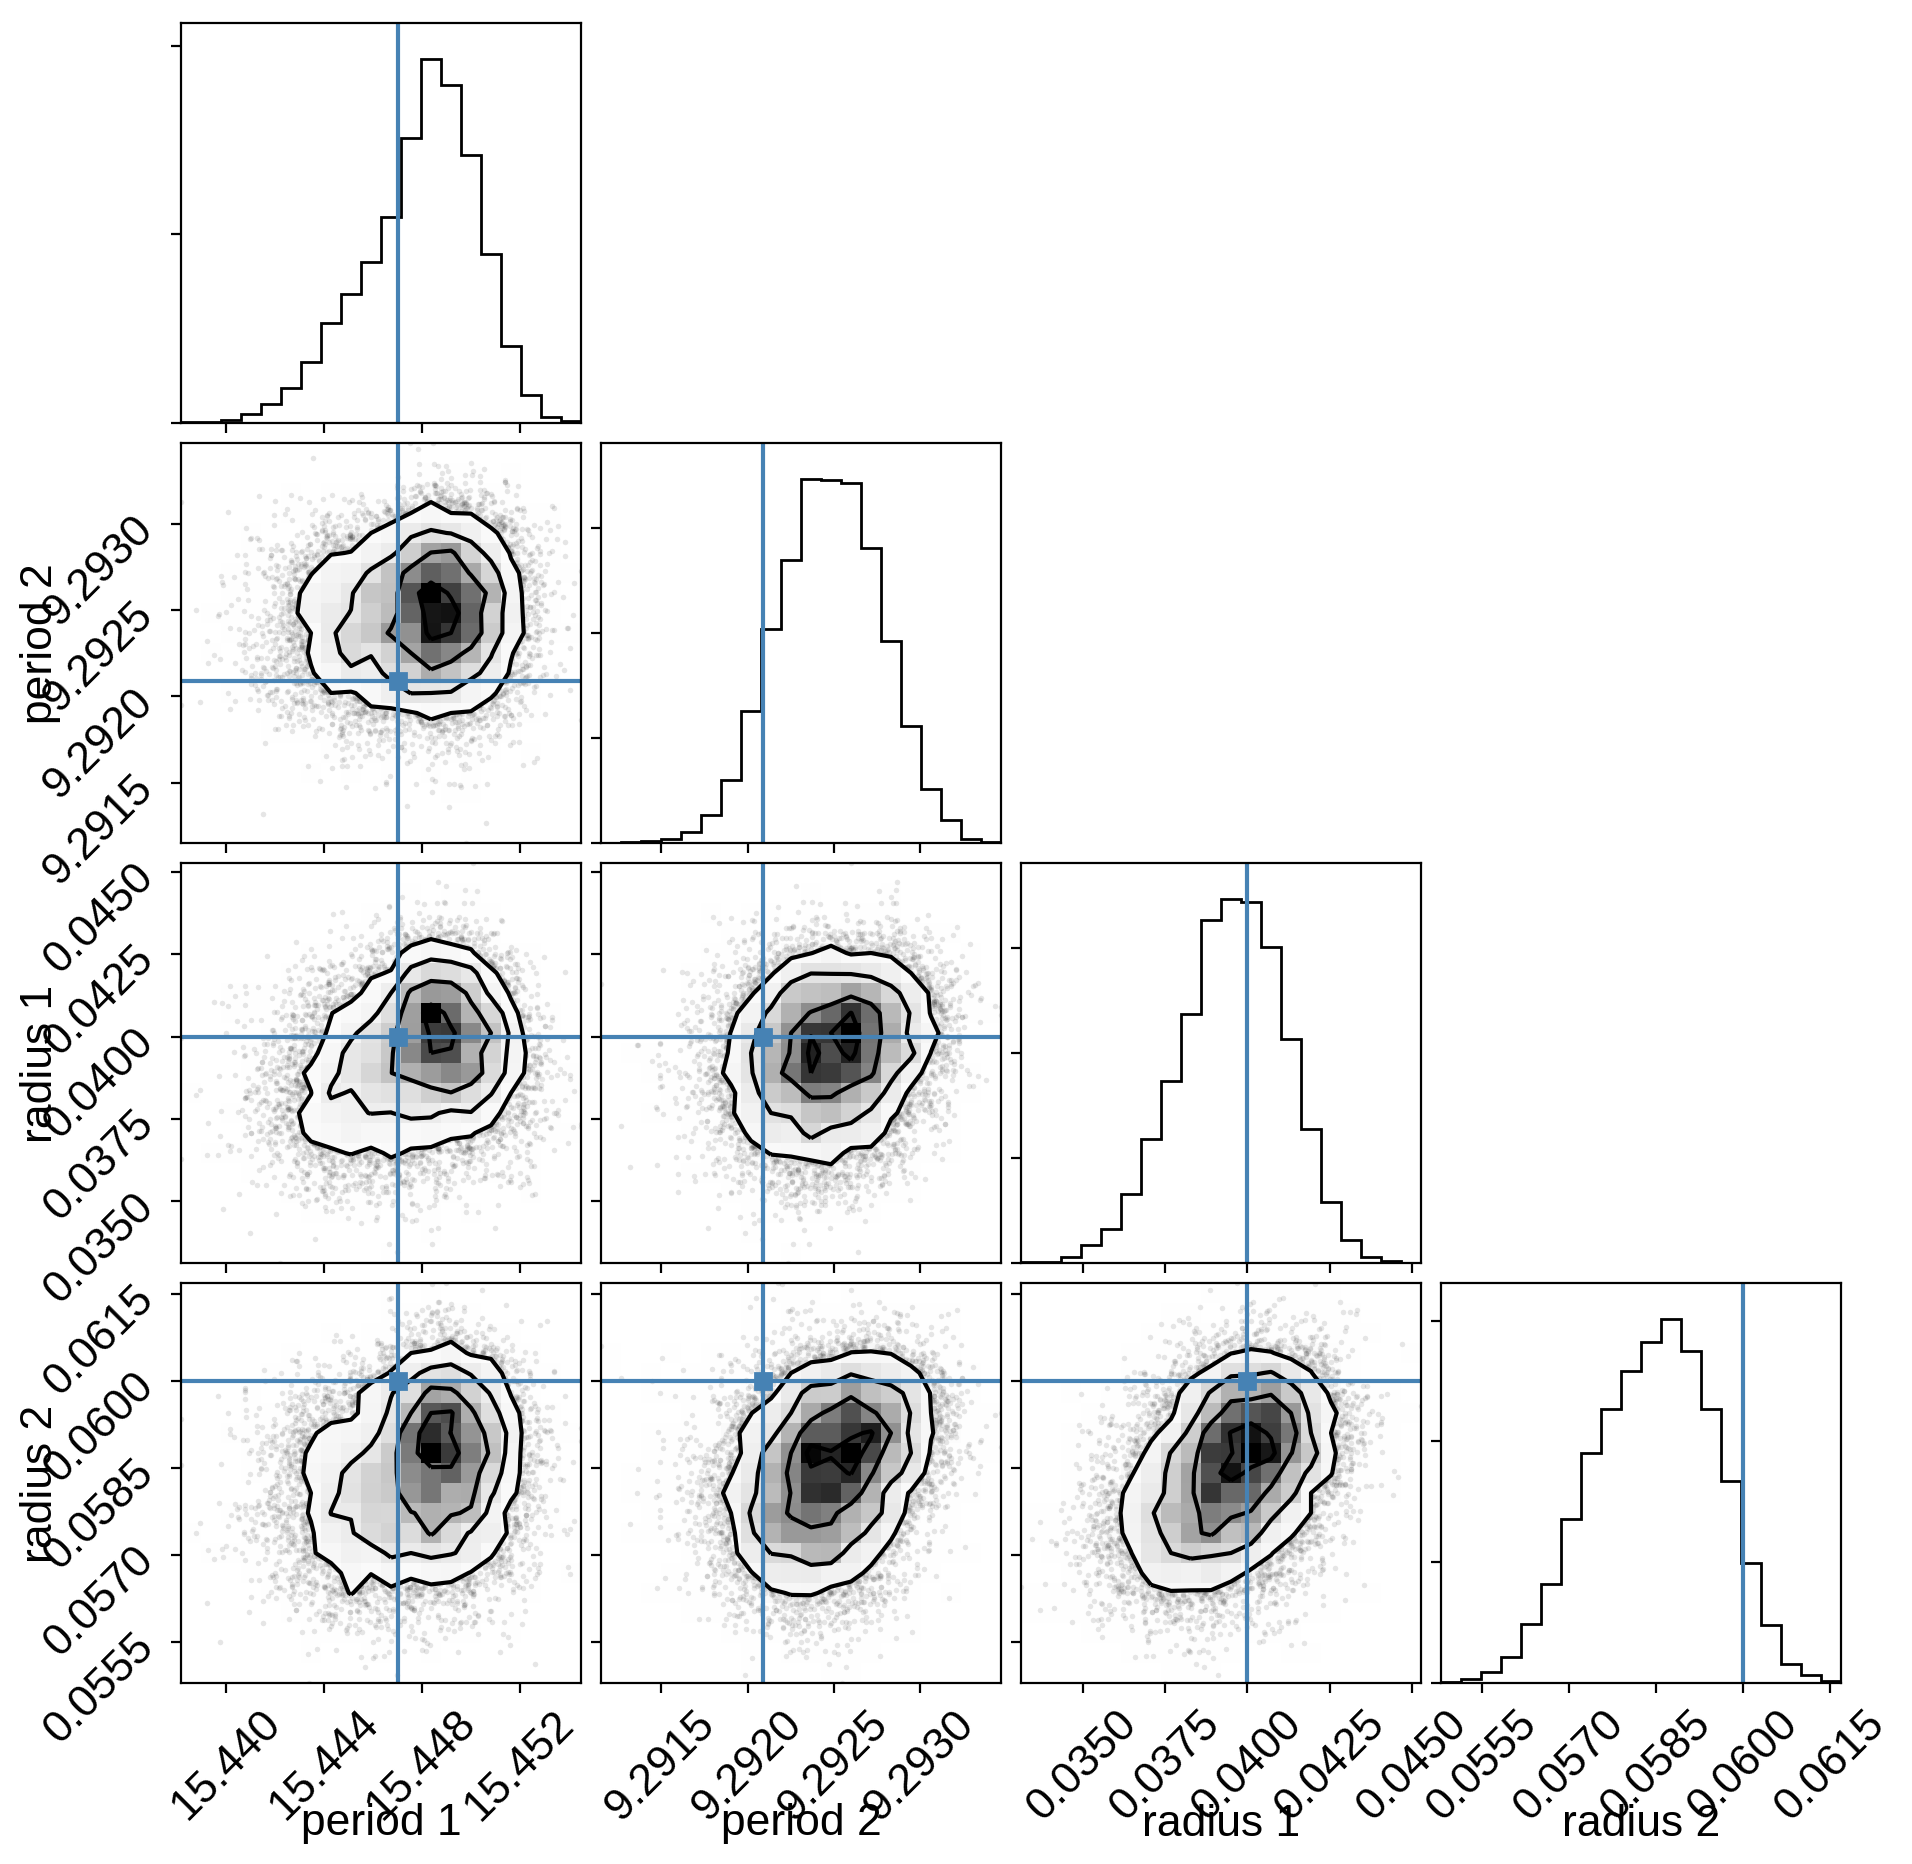

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

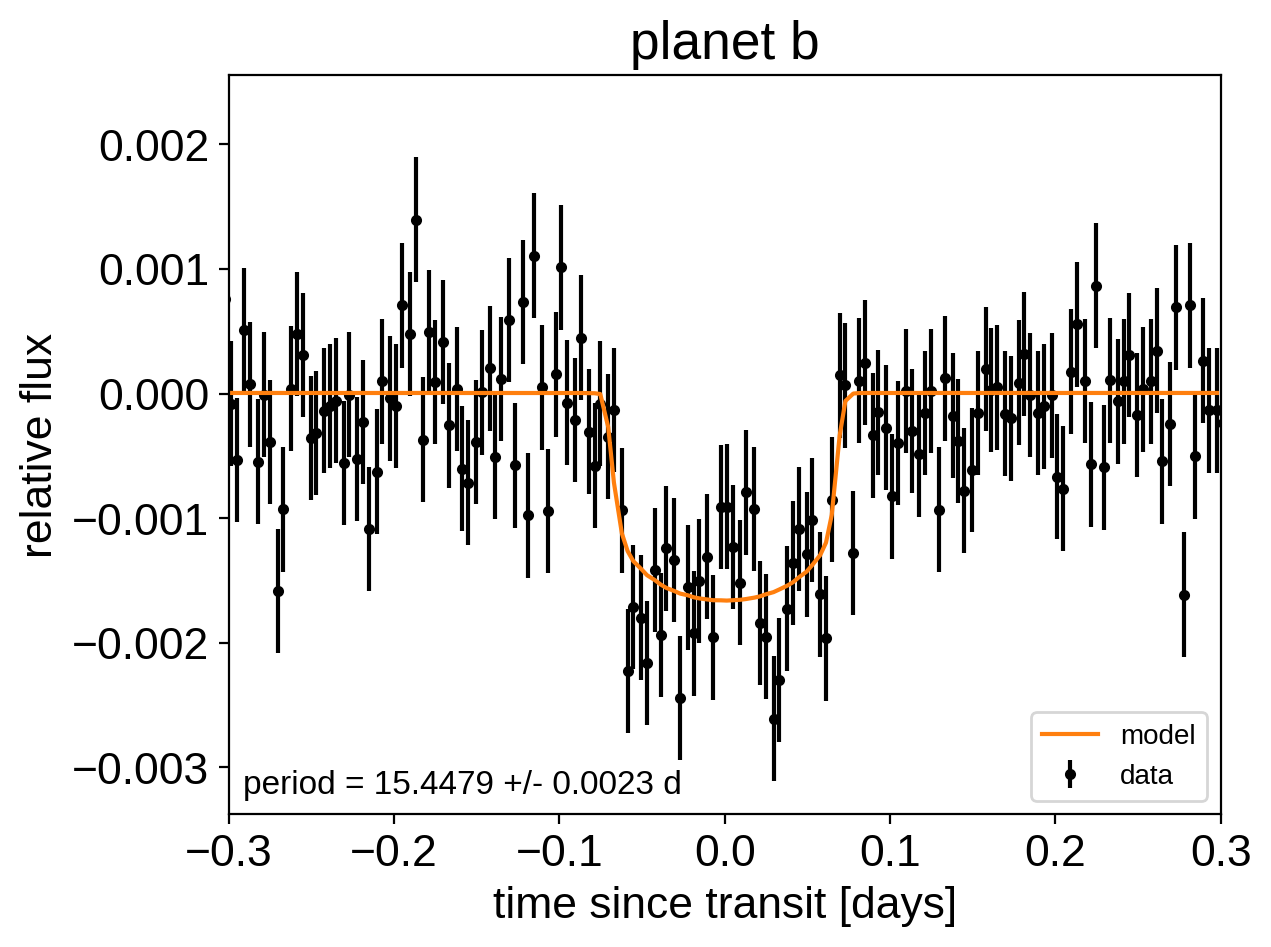

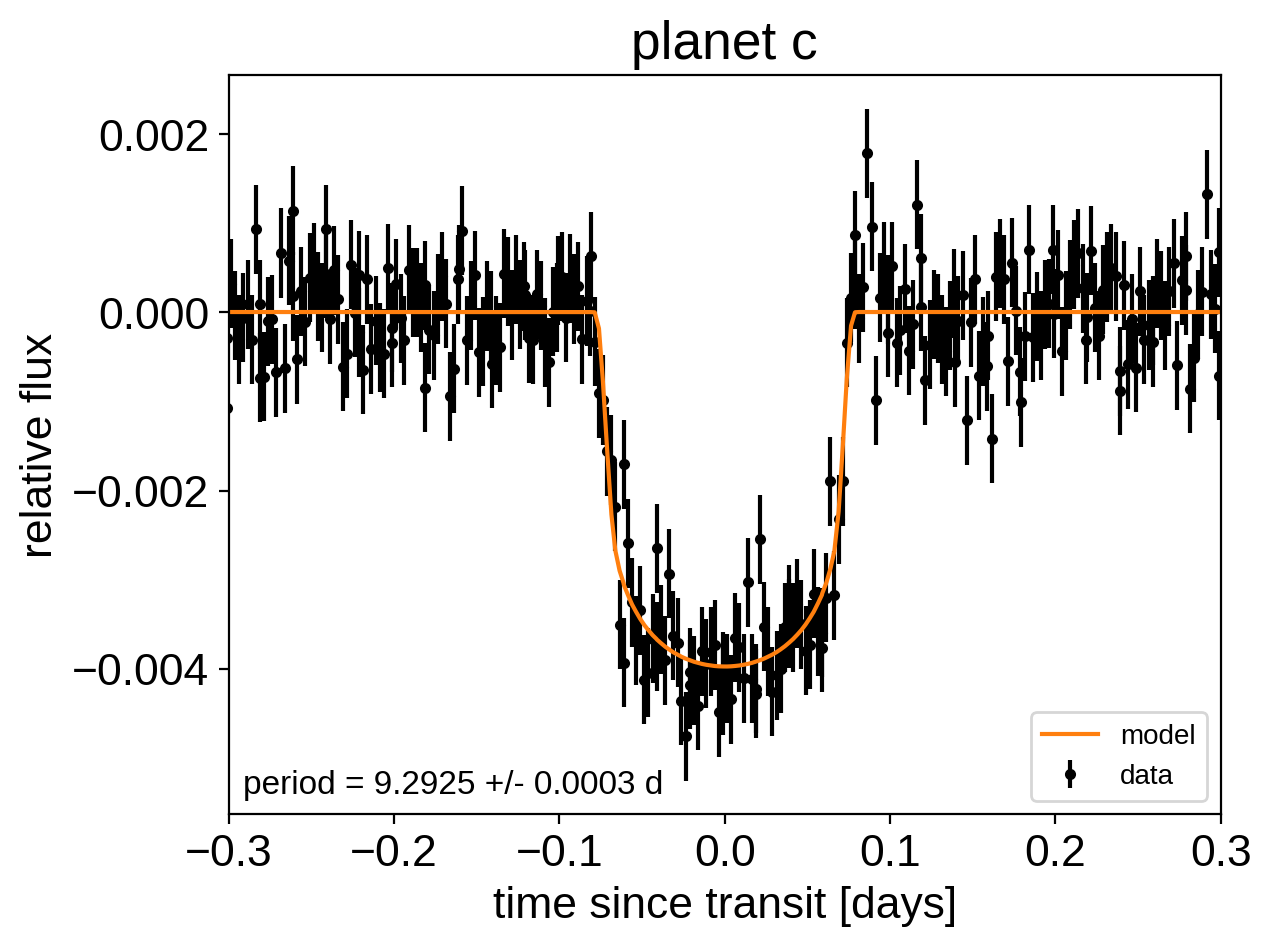

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
